In [30]:
import ee              
import cv2                      
import numpy as np
from sklearn.cluster import KMeans
import pydensecrf.densecrf as dcrf
import matplotlib.pyplot as plt


- Google Earth Engine (GEE) API is used to fetch satellite imagery and elevation (free for non-commercial use).
- OpenCV and NumPy handle image I/O and processing.
- scikit-learn provides KMeans clustering for initial labeling.
- pydensecrf implements a dense CRF inference for segmentation.

In [31]:
ee.Initialize()


lat, lon = 9.03, 38.74
point = ee.Geometry.Point(lon, lat)
region = point.buffer(3000) 

print("type of point:",type(point))
print("type of region:",type(region))


collection = (
    ee.ImageCollection("COPERNICUS/S2_SR") ## load the dataset(surface reflection images) 
    .filterBounds(point)    ## filters the dataset to include only images with geographic coverage overlap with the point defined above
    .filterDate("2020-01-01", "2020-12-31")     ## time filter 
    .sort("CLOUDY_PIXEL_PERCENTAGE")    ## Sorts images in ascending order based on the CLOUDY_PIXEL_PERCENTAGE
)
print("type of:",type(collection))

image = collection.first().select(["B4", "B3", "B2"]) 

type of point: <class 'ee.geometry.Geometry'>
type of region: <class 'ee.geometry.Geometry'>
type of: <class 'ee.imagecollection.ImageCollection'>


Earth engine is initialized after authentication to prepare the google earth engine python library to communicate with google's servers which enables to analyze geospatial data. Then longitude and latitude are defined to pinpoint the center point for the area of interest using `ee.Geometry.Point(lon,lat)`. The coordinates initialized are then used to create the area of interest by drawing a circle around it with a 300-meter radius using the `point.buffer()`. After completing this, we have the center point stored in the `point` variable and the area of interest in the `region` variable, and both are geometry objects like:

```json
ee.Geometry({
    'type': 'Polygon',
    'coordinates': [[[lon1, lat1], [lon2, lat2], …]]
})
```
* then the sentinel-2 collection is loaded. Sentinel‑2 is a pair of Earth-observing satellites from the European Space Agency (ESA) under the Copernicus program. They capture high-resolution images (10–60 m per pixel) of the land and coastal areas every 5 days worldwide .S2_SR specifically refers to the Surface Reflectance product, known as Level‑2A data. This means the raw satellite measurements have been calibrated and corrected for atmospheric effects, giving you values that more accurately represent real ground condition  
    - code reference : https://developers.google.com/earth-engine/apidocs/ee-imagecollection


collection we have an ee.imagecollection.ImageCollection object(It’s a key class that holds many images like a photo album of satellite snapshots stacked over time or across different areas.) 
then picked the first image in the collection
- `.first()` picks the best image—the one with the lowest cloud cover—from the filtered collection  
- `.select(["B4", "B3", "B2"])` extracts just the red, green, and blue bands, producing a true-color image.


In [32]:
image = image.clip(region)
thumb = image.getThumbURL(
    {
        "min": 0,
        "max": 3000,
        "dimensions": "350x350",
        "region": region,
        "format": "PNG",
    }
)

print(thumb)

https://earthengine.googleapis.com/v1/projects/map-environmental-features/thumbnails/8afd13de3be69a7775089010efabd30e-95fad110903d28f792b72abe749f3cfb:getPixels


* the `clip()` function which is the part of ee library is used to restrict the image to the specified geometric region 
then `getThumbURL()` Generates a URL that, when accessed, returns a thumbnail image rendered based on your specifications (e.g., size, stretch, region).
    - https://developers.google.com/earth-engine/apidocs/ee-image-getthumburl   

In [33]:
import requests

resp = requests.get(thumb)
img_arr = cv2.imdecode(np.frombuffer(resp.content, np.uint8), cv2.IMREAD_COLOR)

img = cv2.resize(img_arr, (350, 350))
print("Satellite image shape:", img.shape)

Satellite image shape: (350, 350, 3)


This block downloads a satellite image from a URL, Decodes that image into a format Python can work with (a NumPy array) using OpenCV, resizes it to 350x350 pixels, and prints its shape.

In [34]:
elv = ee.Image('USGS/SRTMGL1_003')

elev_fc = elv.sample(region=point, numPixels=1)
elev_feat = elev_fc.first()
elevation = elev_feat.get('elevation').getInfo() 
print(f"Elevation at ({lat}, {lon}): {elevation:.1f} meters")


Elevation at (9.03, 38.74): 2442.0 meters


* This block retrieves the elevation at a specific geographic location using SRTM(It stands for the Shuttle Radar Topography Mission (SRTM) Global 1 arc-second Digital Elevation Model (DEM) ,It provides detailed terrain elevation information worldwide.) elevation data from Google Earth Engine and prints it.

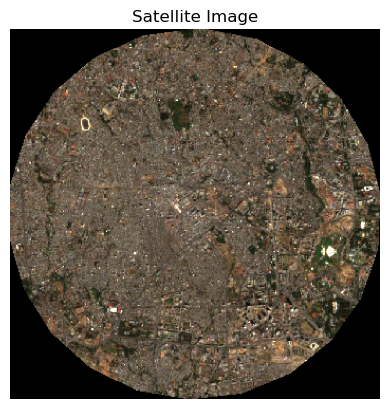

In [35]:
## Convert image from BGR (OpenCV) to HSV color space
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
H, W = hsv_img.shape[:2]

## Prepare a 2D array of pixel features (HSV values) for clustering/CRF
pixels = hsv_img.reshape(-1, 3)  ## shape: (350*350, 3)

## (Optional) Display the raw image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Satellite Image"); plt.axis('off'); plt.show()


the above block converts your satellite image into a color space better suited for analysis, then prepares the pixel data in a format ready for further processing or segmentation, and optionally displays the image.


The first step in analyzing the satellite image is to convert it from OpenCV’s default BGR color space to the HSV (Hue, Saturation, Value) color space. Unlike BGR or RGB, HSV separates the color information (hue) from brightness (value) and intensity (saturation), making it easier to identify different types of land cover, such as forests or grassy areas, regardless of lighting conditions or shadows. Once converted, the image which is originally a three-dimensional array representing height, width, and color channels is reshaped into a two-dimensional array where each row corresponds to a pixel and each column to its HSV components. This reshaping is essential because many machine learning and image segmentation algorithms expect input data in this tabular form, allowing them to analyze each pixel’s color characteristics independently. Finally, the image is optionally displayed after converting back from BGR to RGB to ensure colors appear correctly in visualization tools like matplotlib. This visual check helps confirm that the image is loaded and processed as intended before proceeding to more complex segmentation tasks. Together, these steps prepare the image data in a way that facilitates accurate and robust environmental feature detection using clustering or graphical models.



###### Segment with a Graphical Model (CRF)
* each pixel is  treated as a node in a grid and connect adjacent pixels. As an approximation, we initialize each pixel’s label (forest, grass, or other) by color clustering (KMeans on HSV). These initial labels define unary potentials: a pixel likely belongs to its cluster with probability e.g. 0.7, and to other classes with the remaining probability. We then run a Dense CRF (a form of Markov Random Field inference) to enforce spatial smoothness
*   This part of the code implements image segmentation using a two-step process:
    - first clustering with K-Means, then 
    - refining with a Dense Conditional Random Field (CRF).
 The goal is to classify each pixel into one of three categories—forest, grass, or other—based on its color properties in HSV space.

In [36]:

M = 3  
kmeans = KMeans(n_clusters=M, random_state=0).fit(pixels)
init_labels = kmeans.labels_.reshape(H, W)

GT_PROB = 0.7  
N = H * W
unary = np.full((M, N), -np.log((1.0 - GT_PROB) / (M - 1)), dtype='float32')
for c in range(M):
    idx = np.where(kmeans.labels_ == c)[0]
    unary[c, idx] = -np.log(GT_PROB)





 
  K-Means clustering is applied first, grouping all pixels into three clusters using their color similarity. These initial labels are only a rough guess, so the code computes unary potentials to express the confidence in each pixel’s assigned class, assuming a 70% probability that the K-Means label is correct. This confidence is then transformed into a penalty using the negative log probability, which is a common approach in probabilistic models to turn probabilities into energy terms.
  


In [37]:

d = dcrf.DenseCRF2D(W, H, M)
d.setUnaryEnergy(unary)


d.addPairwiseGaussian(sxy=3, compat=3)
d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=img, compat=10)

Q = d.inference(5)
labels_crf = np.argmax(np.array(Q), axis=0).astype(np.uint8).reshape(H, W)

   Next, a Dense CRF model is set up to refine the segmentation by incorporating spatial and color relationships between pixels. The CRF encourages neighboring pixels to share the same label through two types of pairwise potentials: a Gaussian kernel that enforces spatial smoothness, and a bilateral kernel that encourages pixels with similar colors and nearby locations to belong to the same class. Finally, the model runs inference for a few iterations to adjust the pixel labels and produce a more coherent segmentation map, where boundaries are cleaner and better aligned with actual object shapes in the image. This step improves the initial guess by reducing noise and enforcing consistency, making the output much more accurate for environmental mapping.

#### Image Segmentation Using K-Means and Dense CRF

This section explains the complete pipeline for segmenting satellite imagery into environmental classes (e.g., forest, grass, other) using an initial unsupervised clustering step (K-Means) followed by refinement through a probabilistic graphical model (Dense Conditional Random Field).

* Objective: The goal is to assign each pixel in an image to one of a few predefined classes using its color and spatial context. This is particularly useful for identifying environmental features from satellite data where boundaries are not always clear.

##### Step 1: Initial Labeling with K-Means Clustering

* Concept: K-Means is an unsupervised clustering algorithm that partitions data points into \( K \) clusters based on feature similarity. In this context, each pixel is treated as a data point, and its HSV color values form the features.

* Mathematical Formulation



Given:
- $x_i \in \mathbb{R}^3$: HSV color vector of pixel $i$
- $\mu_k$: Centroid of cluster $k$


K-Means minimizes the within-cluster variance:

$$
\sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2
$$


Output: Each pixel receives an initial label (0, 1, or 2) indicating which cluster it belongs to. This label is treated as the most probable class for that pixel.



#### Step 2: Unary Potentials from Clustering

Concept: Unary potentials represent the cost of assigning each pixel to each possible class independently. They reflect our confidence in the initial K-Means labels and form the data term of the CRF energy function.

##### Probability-Based Assignment

Assume:

- $M$: number of classes (here, 3)  
- $N$: total number of pixels  
- $P(y_i = c)$: confidence in assigning pixel $i$ to class $c$

Using the K-Means label as the ground truth guess, set:

- For the assigned class: $P = 0.7$  
- For other classes: $P = \dfrac{1 - 0.7}{M - 1}$

##### Unary Energy

Unary energy is computed as:

$$
U(c, i) = -\log P(y_i = c)
$$

This yields an $M \times N$ matrix of costs, where each entry represents the cost of assigning class $c$ to pixel $i$.

#### Step 3: Dense CRF Model for Refinement

Concept: Conditional Random Fields (CRFs) are probabilistic models that define relationships between neighboring pixels. A Dense CRF connects all pixels to each other, not just local neighbors, and refines the initial labels by encouraging smooth and coherent regions.

Energy Function : The CRF defines an energy function:

$$
E(y) = \sum_i U(y_i) + \sum_{i < j} P(y_i, y_j)
$$

Where:

- $U(y_i)$: unary potential from K-Means  
- $P(y_i, y_j)$: pairwise potential between pixel $i$ and $j$

* Pairwise Potentials

    - Two types of pairwise potentials are used:

        - 4.1. Gaussian Kernel (Spatial Smoothness)

            - Encourages nearby pixels to have similar labels:

                - $$ P_{ij}^{\text{gaussian}} = w_1 \cdot \exp\left( -\frac{\| p_i - p_j \|^2}{2\sigma_\alpha^2} \right) $$

            - Where $p_i$ and $p_j$ are the spatial positions of pixels $i$ and $j$.

        - 4.2. Bilateral Kernel (Appearance Consistency)

            - Encourages similar-looking and nearby pixels to have similar labels:

                - $$ P_{ij}^{\text{bilateral}} = w_2 \cdot \exp\left( -\frac{\| p_i - p_j \|^2}{2\sigma_\alpha^2} - \frac{\| I_i - I_j \|^2}{2\sigma_\beta^2} \right) $$

                - Where $I_i$ and $I_j$ are the RGB values of the pixels.




#### Step 4: Inference

Concept: Inference in a CRF seeks to find the label assignment \( y \) that minimizes the total energy \( E(y) \). Due to the dense connections, exact inference is intractable, so **mean-field approximation** is used.

Implementation: The method runs inference for a small number of iterations (e.g., 5), refining label probabilities. The final label for each pixel is selected as the class with the highest probability.



#### Output

The final output is a segmentation map where each pixel is assigned a class label. Compared to the raw K-Means result, the CRF output is:

- Smoother and more coherent.
- Better aligned with real-world object boundaries.
- Less noisy, especially in uniform regions.



| Stage               | Technique Used        | Purpose                                             | 
|---------------------|------------------------|--------------------------------------------------|
| Initialization       | K-Means clustering     | Quickly assign rough labels to pixels           |
| Unary potentials     | Log-probability matrix | Quantify per-class confidence per pixel         |
| Pairwise potentials  | Gaussian + Bilateral   | Enforce spatial and appearance consistency      |
| Inference            | Mean-field CRF         | Optimize label assignment based on energy model |
| Final Output         | Segmentation map       | Clean, refined pixel labels for classification  |




#### Visualize Results
Identify which class corresponds to forest or grass by analyzing the color of each label. We assume the darkest (lowest brightness) cluster is forest and a lighter-green cluster is grass. We then find connected components of each class and draw lines from the image center to these cluster centers. Forest clusters are circled in blue (if within 200 ft) or red (200–1000 ft), and grass clusters in light blue or orange similarly.

In [ ]:
mean_vals = [np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[labels_crf == c]) for c in range(M)]
forest_label = int(np.argmin(mean_vals))
other_label = int(np.argmax(mean_vals))
grass_label = 3 - forest_label - other_label  

mask_forest = (labels_crf == forest_label).astype(np.uint8)
mask_grass  = (labels_crf == grass_label).astype(np.uint8)

In [ ]:
Hc, Wc = H//2, W//2 
scale_m_per_px = 0.583 

for mask, color_near, color_far in [
    (mask_forest, (255, 0, 0), (0, 0, 255)),   
    (mask_grass,  (255, 200, 0), (0, 165, 255))]: 
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        M_cnt = cv2.moments(cnt)
        if M_cnt["m00"] == 0: 
            continue
        cx = int(M_cnt["m10"] / M_cnt["m00"])
        cy = int(M_cnt["m01"] / M_cnt["m00"])

        dist_m = np.sqrt((cx - Wc)**2 + (cy - Hc)**2) * scale_m_per_px
        dist_ft = dist_m * 3.28084
        color = color_near if dist_ft <= 200 else color_far
    
        cv2.line(img, (Wc, Hc), (cx, cy), color, 2)
        cv2.circle(img, (cx, cy), 5, color, -1)

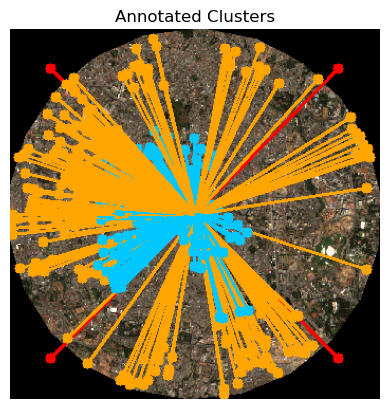

In [ ]:
cv2.imwrite('segmented_clusters.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Annotated Clusters"); plt.axis('off'); plt.show()

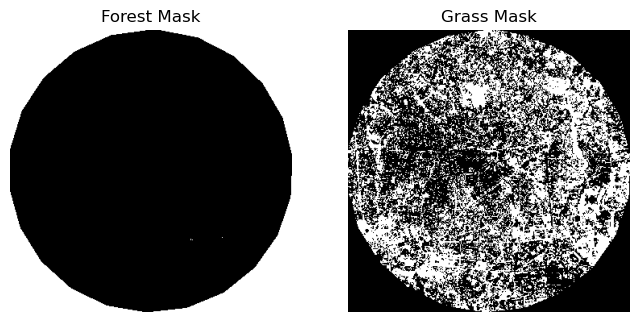

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(mask_forest, cmap='gray'); plt.title("Forest Mask"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask_grass,  cmap='gray'); plt.title("Grass Mask");  plt.axis('off')
plt.show()

In [43]:
print("Annotated image saved. Elevation:", elevation, "m")


Annotated image saved. Elevation: 2442 m
